In [7]:
# %pip install xgboost pandas numpy matplotlib seaborn lightgbm scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import os

In [ ]:
os.makedirs("./Output", exist_ok=True)
os.makedirs("./Final_Result", exist_ok=True)

## 1. Data loading and exploration

##### Load datasets

In [ ]:
sales_df = pd.read_csv("sales_data.csv")
stocks_df = pd.read_csv("stocks_data.csv")

##### Basic dataset info

In [ ]:
print("Sales Data:")
print(f"Shape: {sales_df.shape}")

Sales Data:
Shape: (2020407, 13)


In [ ]:
print("\nStocks Data:")
print(f"Shape: {stocks_df.shape}")


Stocks Data:
Shape: (486180, 6)


##### Check for missing values

In [ ]:
print("Sales data missing values:")
print(sales_df.isnull().sum())

Sales data missing values:
sales_date           0
sep_region           0
category             0
product              0
dealer_code          0
sales_agent_code     0
payment_method       0
type_of_contract     0
total_price          0
deposit_amount       0
payment_frequency    0
daily_rate           0
qty                  0
dtype: int64


In [ ]:
print("\nStocks data missing values:")
print(stocks_df.isnull().sum())


Stocks data missing values:
benchmark_date    0
ec_region         0
category          0
product_name      0
ec_id             0
inventory_qty     0
dtype: int64


##### Check date ranges

In [ ]:
print(f"Sales date range: {sales_df['sales_date'].min()} to {sales_df['sales_date'].max()}")
print(f"Stocks date range: {stocks_df['benchmark_date'].min()} to {stocks_df['benchmark_date'].max()}")

Sales date range: 2020-01-01 to 2022-12-30
Stocks date range: 2020-01-01 to 2022-12-30


##### Check unique values

In [ ]:
print(f"Stores in sales: {sales_df['dealer_code'].nunique()}")
print(f"Products in sales: {sales_df['product'].nunique()}")
print(f"Stores in stocks: {stocks_df['ec_id'].nunique()}")
print(f"Products in stocks: {stocks_df['product_name'].nunique()}")

Stores in sales: 4
Products in sales: 111
Stores in stocks: 4
Products in stocks: 111


##### Basic statistics

In [ ]:
print("Sales quantity stats:")
print(sales_df['qty'].describe())

Sales quantity stats:
count    2.020407e+06
mean     7.439249e+00
std      1.265559e+01
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      8.000000e+00
max      2.820000e+02
Name: qty, dtype: float64


In [ ]:
print("\nStock inventory stats:")
print(stocks_df['inventory_qty'].describe())


Stock inventory stats:
count    486180.000000
mean        234.117884
std         229.846200
min          14.000000
25%          98.750000
50%         164.000000
75%         253.000000
max        1201.000000
Name: inventory_qty, dtype: float64


## 2. Data Aggregation & Feature Engineering

##### Convert dates to datetime

In [9]:
sales_df['sales_date'] = pd.to_datetime(sales_df['sales_date'])
stocks_df['benchmark_date'] = pd.to_datetime(stocks_df['benchmark_date'])

##### Aggregate sales

In [10]:
daily_sales = sales_df.groupby(['sales_date', 'dealer_code', 'product']).agg({
    'qty': 'sum', 
    'total_price': 'sum'
}).reset_index()
daily_sales.columns = ['sales_date', 'dealer_code', 'product', 'daily_sales_qty', 'daily_revenue']

##### Prepare stocks data for merging

In [ ]:
stocks_renamed = stocks_df.rename(columns={
    'benchmark_date': 'sales_date', 'ec_id': 'dealer_code', 
    'product_name': 'product', 'inventory_qty': 'ending_inventory'
})

In [ ]:
final_data = pd.merge(daily_sales, stocks_renamed[['sales_date', 'dealer_code', 'product', 'ending_inventory']],
                     on=['sales_date', 'dealer_code', 'product'], how='inner')

In [ ]:
# Sort for time series
final_data = final_data.sort_values(['dealer_code', 'product', 'sales_date'])

In [ ]:
# Essential features only
final_data['day_of_week'] = final_data['sales_date'].dt.dayofweek
final_data['month'] = final_data['sales_date'].dt.month
final_data['sales_lag_1'] = final_data.groupby(['dealer_code', 'product'])['daily_sales_qty'].shift(1)
final_data['sales_lag_7'] = final_data.groupby(['dealer_code', 'product'])['daily_sales_qty'].shift(7)
final_data['sales_rolling_7'] = final_data.groupby(['dealer_code', 'product'])['daily_sales_qty'].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)

In [ ]:
# 1. Encode categorical variables properly
final_data['dealer_code_encoded'] = final_data['dealer_code'].astype('category').cat.codes
final_data['product_encoded'] = final_data['product'].astype('category').cat.codes

# 2. Add store-product specific features
final_data['store_product_avg_sales'] = final_data.groupby(['dealer_code', 'product'])['daily_sales_qty'].transform('mean')
final_data['store_product_std_sales'] = final_data.groupby(['dealer_code', 'product'])['daily_sales_qty'].transform('std')

# 3. Add more temporal features
final_data['year'] = final_data['sales_date'].dt.year
final_data['quarter'] = final_data['sales_date'].dt.quarter
final_data['is_weekend'] = (final_data['day_of_week'] >= 5).astype(int)

# 4. Add price-related features if available
if 'daily_revenue' in final_data.columns and 'daily_sales_qty' in final_data.columns:
    final_data['avg_unit_price'] = final_data['daily_revenue'] / (final_data['daily_sales_qty'] + 1)

# 5. Add inventory turnover features
final_data['inventory_turnover'] = final_data['daily_sales_qty'] / (final_data['ending_inventory'] + 1)

final_data = final_data.fillna(0)

In [ ]:
final_data = final_data.fillna(0)
final_data.to_csv("./Output/Complete_Enhanced_Dataset.csv", index=False)

In [ ]:
print(f"Final dataset: {final_data.shape}")

Final dataset: (486180, 20)


In [ ]:
# Quick validation of the features we created
print("\n=== FEATURE VALIDATION ===")
print(f"Dataset shape: {final_data.shape}")
print(f"Unique stores encoded: {final_data['dealer_code_encoded'].nunique()}")
print(f"Unique products encoded: {final_data['product_encoded'].nunique()}")
print(f"Store-product combinations: {final_data[['dealer_code', 'product']].drop_duplicates().shape[0]}")

# Check if different products have different averages
sample_check = final_data[['product', 'product_encoded', 'store_product_avg_sales']].drop_duplicates().head(10)
print("\nSample product encodings and averages:")
print(sample_check.sort_values('store_product_avg_sales', ascending=False))

# Check data distribution
print(f"\nTarget variable (daily_sales_qty) stats:")
print(f"  Min: {final_data['daily_sales_qty'].min()}")
print(f"  Max: {final_data['daily_sales_qty'].max()}")
print(f"  Mean: {final_data['daily_sales_qty'].mean():.2f}")
print(f"  Std: {final_data['daily_sales_qty'].std():.2f}")


=== FEATURE VALIDATION ===
Dataset shape: (486180, 20)
Unique stores encoded: 4
Unique products encoded: 111
Store-product combinations: 444

Sample product encodings and averages:
                                             product  product_encoded  \
8     Arrowhead Mills Organic Whole Wheat Bread 24oz                8   
5         Annie's Homegrown Organic Mac & Cheese 6oz                5   
4  Annie's Homegrown Organic Bunny Fruit Snacks 12ct                4   
3                 Adidas Ultraboost 22 Running Shoes                3   
0                   3M Scotch Double-Sided Tape 6636                0   
2                               Adidas Ultraboost 22                2   
1                           Acer Predator Helios 300                1   
6                          Apple AirPods Pro 2nd Gen                6   
9                              Asus ROG Zephyrus G14                9   
7                Arm & Hammer Super Scoop Cat Litter                7   

   store_produ

## 3: Data Description & Analysis

##### Load the dataset

In [ ]:
df = pd.read_csv("./Output/Complete_Enhanced_Dataset.csv")
df['sales_date'] = pd.to_datetime(df['sales_date'])

##### Basic overview

In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['sales_date'].min()} to {df['sales_date'].max()}")
print(f"Stores: {df['dealer_code'].nunique()}, Products: {df['product'].nunique()}")

Dataset shape: (486180, 20)
Date range: 2020-01-01 00:00:00 to 2022-12-30 00:00:00
Stores: 4, Products: 111


##### Key statistics

In [ ]:
print("\nKey Statistics:")
print(df[['daily_sales_qty', 'daily_revenue', 'ending_inventory']].describe())


Key Statistics:
       daily_sales_qty  daily_revenue  ending_inventory
count    486180.000000  486180.000000     486180.000000
mean         30.915114    4797.056046        234.117884
std          33.402376    7711.034145        229.846200
min           1.000000      33.720000         14.000000
25%          12.000000     855.120000         98.750000
50%          20.000000    2156.220000        164.000000
75%          35.000000    5372.000000        253.000000
max         283.000000  123440.720000       1201.000000


##### Time patterns

In [ ]:
print("\nSeasonal Patterns:")
print("Monthly averages:", df.groupby('month')['daily_sales_qty'].mean().round(2).to_dict())
print("Weekday averages:", df.groupby('day_of_week')['daily_sales_qty'].mean().round(2).to_dict())


Seasonal Patterns:
Monthly averages: {1: 28.77, 2: 28.62, 3: 28.05, 4: 28.66, 5: 28.87, 6: 28.09, 7: 28.89, 8: 28.37, 9: 28.35, 10: 29.02, 11: 42.63, 12: 42.72}
Weekday averages: {0: 24.5, 1: 24.61, 2: 24.57, 3: 24.58, 4: 39.49, 5: 39.25, 6: 39.43}


##### Feature correlations (for model justification)

In [ ]:
print("\nTop Feature Correlations with Sales:")
correlations = df[['daily_sales_qty', 'sales_lag_1', 'sales_lag_7', 'sales_rolling_7']].corr()
print(correlations['daily_sales_qty'].sort_values(ascending=False))


Top Feature Correlations with Sales:
daily_sales_qty    1.000000
sales_rolling_7    0.907169
sales_lag_7        0.895042
sales_lag_1        0.848352
Name: daily_sales_qty, dtype: float64


##### Data quality

In [ ]:
zero_sales = (df['daily_sales_qty'] == 0).mean() * 100
print(f"\nData Quality: {zero_sales:.1f}% zero sales days")


Data Quality: 0.0% zero sales days


## 4: Train-Test Split (Time-Based)

##### Load feature-engineered dataset

In [ ]:
df = pd.read_csv("./Output/Complete_Enhanced_Dataset.csv")
df['sales_date'] = pd.to_datetime(df['sales_date'])
df = df.sort_values('sales_date')

##### Get unique dates and split chronologically

In [ ]:
unique_dates = sorted(df['sales_date'].unique())
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

##### Split data based on dates

In [ ]:
train_data = df[df['sales_date'].isin(train_dates)]
test_data = df[df['sales_date'].isin(test_dates)]

##### Verify no data leakage

In [ ]:
max_train_date = train_data['sales_date'].max()
min_test_date = test_data['sales_date'].min()

print(f"Total records: {len(df):,}")
print(f"Train set: {len(train_data):,} records ({len(train_data)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_data):,} records ({len(test_data)/len(df)*100:.1f}%)")
print(f"Train date range: {train_data['sales_date'].min()} to {train_data['sales_date'].max()}")
print(f"Test date range: {test_data['sales_date'].min()} to {test_data['sales_date'].max()}")
print(f"No data leakage: {max_train_date < min_test_date}")

Total records: 486,180
Train set: 388,944 records (80.0%)
Test set: 97,236 records (20.0%)
Train date range: 2020-01-01 00:00:00 to 2022-05-25 00:00:00
Test date range: 2022-05-26 00:00:00 to 2022-12-30 00:00:00
No data leakage: True


##### Save splits

In [ ]:
train_data.to_csv("./Output/train_data.csv", index=False)
test_data.to_csv("./Output/test_data.csv", index=False)

print("Time-Based Train-Test Split Complete")

Time-Based Train-Test Split Complete


## 5: LightGBM Model Development

##### Load train and test data

In [ ]:
train_data = pd.read_csv("./Output/train_data.csv")
test_data = pd.read_csv("./Output/test_data.csv")

In [ ]:
print(f"Train data columns: {list(train_data.columns)}")
print(f"Train data shape: {train_data.shape}")

Train data columns: ['sales_date', 'dealer_code', 'product', 'daily_sales_qty', 'daily_revenue', 'ending_inventory', 'day_of_week', 'month', 'sales_lag_1', 'sales_lag_7', 'sales_rolling_7', 'dealer_code_encoded', 'product_encoded', 'store_product_avg_sales', 'store_product_std_sales', 'year', 'quarter', 'is_weekend', 'avg_unit_price', 'inventory_turnover']
Train data shape: (388944, 20)


##### Check for the critical features we added

In [ ]:
critical_features = ['dealer_code_encoded', 'product_encoded', 'store_product_avg_sales', 'store_product_std_sales']
missing_critical = [feat for feat in critical_features if feat not in train_data.columns]
if missing_critical:
    print(f"CRITICAL: Missing features: {missing_critical}")
else:
    print("All critical features present")

All critical features present


##### Prepare features and target - exclude object columns

In [ ]:
exclude_cols = ['sales_date', 'daily_sales_qty', 'daily_revenue', 'dealer_code', 'product']
feature_cols = [col for col in train_data.columns if col not in exclude_cols and train_data[col].dtype in ['int64', 'float64']]

print(f"Total features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

Total features: 15
Features: ['ending_inventory', 'day_of_week', 'month', 'sales_lag_1', 'sales_lag_7', 'sales_rolling_7', 'dealer_code_encoded', 'product_encoded', 'store_product_avg_sales', 'store_product_std_sales', 'year', 'quarter', 'is_weekend', 'avg_unit_price', 'inventory_turnover']


In [ ]:
# Check feature variation
print("\n=== FEATURE VARIATION ANALYSIS ===")
for col in feature_cols[:10]:  # Check first 10 features
    unique_vals = train_data[col].nunique()
    print(f"  {col}: {unique_vals} unique values")


=== FEATURE VARIATION ANALYSIS ===
  ending_inventory: 1185 unique values
  day_of_week: 7 unique values
  month: 12 unique values
  sales_lag_1: 284 unique values
  sales_lag_7: 284 unique values
  sales_rolling_7: 1885 unique values
  dealer_code_encoded: 4 unique values
  product_encoded: 111 unique values
  store_product_avg_sales: 442 unique values
  store_product_std_sales: 444 unique values


In [ ]:
# Check if we have store/product specific features
store_product_features = [col for col in feature_cols if 'dealer_code' in col or 'product' in col or 'store' in col]
print(f"\nStore/Product features: {store_product_features}")


Store/Product features: ['dealer_code_encoded', 'product_encoded', 'store_product_avg_sales', 'store_product_std_sales']


In [ ]:
if len(store_product_features) == 0:
    print("WARNING: No store/product specific features found!")
    print("This will cause identical predictions across all products/stores")
else:
    print(f"Found {len(store_product_features)} store/product features")

Found 4 store/product features


In [ ]:
X_train = train_data[feature_cols]
y_train = train_data['daily_sales_qty']
X_test = test_data[feature_cols]
y_test = test_data['daily_sales_qty']

##### Identify categorical features for LightGBM (only encoded ones)

In [ ]:
categorical_features = [col for col in ['dealer_code_encoded', 'product_encoded'] if col in feature_cols]

##### Create LightGBM dataset

In [ ]:
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_dataset = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, reference=train_dataset)

##### Set hyperparameters

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

##### Train model with early stopping

In [ ]:
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=10000,
    valid_sets=[train_dataset, test_dataset],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.64381	valid's rmse: 1.90156
[200]	train's rmse: 1.02451	valid's rmse: 1.27849
[300]	train's rmse: 0.841611	valid's rmse: 1.13418
[400]	train's rmse: 0.747964	valid's rmse: 1.07478
[500]	train's rmse: 0.687781	valid's rmse: 1.04868
[600]	train's rmse: 0.644437	valid's rmse: 1.03412
[700]	train's rmse: 0.609925	valid's rmse: 1.02043
[800]	train's rmse: 0.58151	valid's rmse: 1.00859
[900]	train's rmse: 0.556875	valid's rmse: 1.00339
[1000]	train's rmse: 0.537252	valid's rmse: 0.999259
[1100]	train's rmse: 0.518908	valid's rmse: 0.993232
[1200]	train's rmse: 0.504379	valid's rmse: 0.990676
[1300]	train's rmse: 0.490407	valid's rmse: 0.986643
[1400]	train's rmse: 0.478105	valid's rmse: 0.984648
[1500]	train's rmse: 0.467932	valid's rmse: 0.982755
[1600]	train's rmse: 0.458424	valid's rmse: 0.981595
[1700]	train's rmse: 0.448601	valid's rmse: 0.97878
[1800]	train's rmse: 0.439503	valid's rmse: 0.976664
[1900]	


##### Make predictions

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("\n=== MODEL DIAGNOSTICS ===")
print(f"Prediction stats: min={y_pred.min():.4f}, max={y_pred.max():.4f}, mean={y_pred.mean():.4f}")
print(f"Unique predictions: {len(np.unique(y_pred))}")


=== MODEL DIAGNOSTICS ===
Prediction stats: min=0.7748, max=283.6884, mean=32.5275
Unique predictions: 96951


In [ ]:
# Check if predictions vary by product/store
test_with_pred = test_data.copy()
test_with_pred['prediction'] = y_pred

In [ ]:
# Check product variation
product_variation = test_with_pred.groupby('product')['prediction'].std()
zero_var_products = (product_variation == 0).sum()
print(f"Products with zero prediction variation: {zero_var_products}/{len(product_variation)}")

Products with zero prediction variation: 0/111


In [ ]:
# Check store variation  
store_variation = test_with_pred.groupby('dealer_code')['prediction'].std()
zero_var_stores = (store_variation == 0).sum()
print(f"Stores with zero prediction variation: {zero_var_stores}/{len(store_variation)}")

Stores with zero prediction variation: 0/4


In [ ]:
# Sample some predictions to verify they're different
sample_products = test_with_pred[['product', 'dealer_code', 'prediction']].drop_duplicates().head(5)
print("\nSample predictions by product/store:")
print(sample_products)


Sample predictions by product/store:
                                             product dealer_code  prediction
0  Hill's Science Diet Adult Sensitive Stomach Do...         S03   14.365370
1  David Yurman Cable Classics 10mm Diamond Accen...         S02    2.049617
2                           Acer Predator Helios 300         S02   13.130107
3                Bosch Home Connect Smart Thermostat         S02   15.963093
4      La Tortilla Factory Whole Wheat Tortillas 8ct         S04   84.536553


##### Calculate metrics

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

def wmape(y_true, y_pred):
    """Weighted Mean Absolute Percentage Error"""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

wmape_score = wmape(y_test, y_pred)

In [ ]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"WMAPE: {wmape_score:.2f}%")  
print(f"Best iteration: {model.best_iteration}")

RMSE: 0.9573
MAE: 0.3531
WMAPE: 1.09%
Best iteration: 3494


##### Save as joblib

In [ ]:
joblib.dump(model, './Output/lightgbm_model.pkl')

['./Output/lightgbm_model.pkl']

##### Save feature information

In [ ]:
feature_info = {
    'feature_names': feature_cols,
    'categorical_features': categorical_features,
    'exclude_cols': exclude_cols,
    'best_iteration': model.best_iteration,
    'rmse': rmse,
    'mae': mae,
    'wmape': wmape_score
}
joblib.dump(feature_info, './Output/lightgbm_feature_info.pkl')

['./Output/lightgbm_feature_info.pkl']

##### Save predictions for evaluation

In [ ]:
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})
predictions_df.to_csv('./Output/lightgbm_predictions.csv', index=False)


=== FEATURE IMPORTANCE ANALYSIS ===
TOP 15 FEATURE IMPORTANCES:
                    feature    importance
5           sales_rolling_7  1.063404e+09
8   store_product_avg_sales  2.592480e+08
14       inventory_turnover  2.396664e+08
0          ending_inventory  1.163176e+08
1               day_of_week  5.455300e+07
4               sales_lag_7  2.042710e+07
7           product_encoded  7.333999e+06
3               sales_lag_1  7.405152e+05
2                     month  4.546944e+05
13           avg_unit_price  2.002709e+05
9   store_product_std_sales  1.586171e+05
6       dealer_code_encoded  1.253432e+05
12               is_weekend  2.697990e+04
10                     year  2.080457e+04
11                  quarter  1.659525e+04

STORE/PRODUCT FEATURE RANKINGS:
                   feature    importance
8  store_product_avg_sales  2.592480e+08
7          product_encoded  7.333999e+06
9  store_product_std_sales  1.586171e+05
6      dealer_code_encoded  1.253432e+05


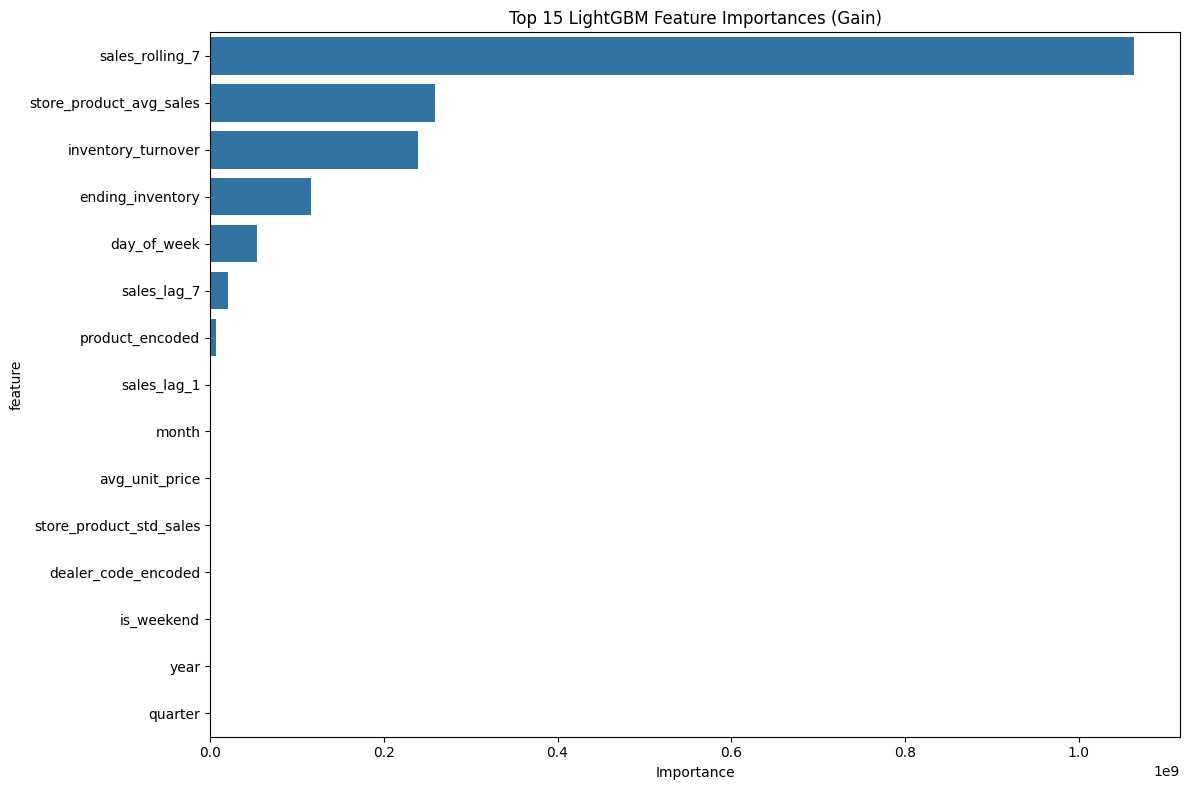


Top 5 most important features: ['sales_rolling_7', 'store_product_avg_sales', 'inventory_turnover', 'ending_inventory', 'day_of_week']
Critical features in top 5: ['store_product_avg_sales']

TOP 10 FEATURE IMPORTANCES (SPLIT):
                    feature  importance_split
14       inventory_turnover             20405
0          ending_inventory             19858
5           sales_rolling_7             14040
4               sales_lag_7             13104
3               sales_lag_1             10525
7           product_encoded              6389
8   store_product_avg_sales              4411
1               day_of_week              4025
2                     month              3464
9   store_product_std_sales              3289


In [ ]:
##### Feature Importance Analysis
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# For LightGBM model - use the correct method
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')  # Use 'gain' or 'split'
}).sort_values('importance', ascending=False)

print("TOP 15 FEATURE IMPORTANCES:")
print(feature_importance.head(15))

# Check if store/product features are important
important_store_product = feature_importance[feature_importance['feature'].isin(store_product_features)]
if len(important_store_product) > 0:
    print("\nSTORE/PRODUCT FEATURE RANKINGS:")
    print(important_store_product)
else:
    print("🚨 WARNING: No store/product features in top importances!")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 15 LightGBM Feature Importances (Gain)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('./Output/lightgbm_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Check if the most important features make sense
top_5_features = feature_importance.head(5)['feature'].tolist()
print(f"\nTop 5 most important features: {top_5_features}")

# Verify critical features are being used
critical_in_top = [feat for feat in critical_features if feat in top_5_features]
print(f"Critical features in top 5: {critical_in_top}")

# Also try split importance for comparison
feature_importance_split = pd.DataFrame({
    'feature': feature_cols,
    'importance_split': model.feature_importance(importance_type='split')
}).sort_values('importance_split', ascending=False)

print("\nTOP 10 FEATURE IMPORTANCES (SPLIT):")
print(feature_importance_split.head(10))

## 7: SVM Model Development


##### Scale features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Try different SVM configurations

In [ ]:
svm_configs = [
    {'kernel': 'rbf', 'C': 0.1, 'epsilon': 0.01},
    {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1},
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'poly', 'C': 1.0, 'degree': 2}
]

In [ ]:
best_rmse = float('inf')
best_config = {}
best_model = None
best_scaler = None
best_wmape = float('inf') 

In [ ]:
for config in svm_configs:
    print(f"Testing config: {config}")
    
    sample_size = min(20000, len(X_train_scaled))
    indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    X_sampled = X_train_scaled[indices]
    y_sampled = y_train.iloc[indices]
    
    svm_model = SVR(**config)
    svm_model.fit(X_sampled, y_sampled)
    
    y_pred = svm_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    wmape_score = wmape(y_test, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_config = config
        best_wmape = wmape_score
        best_model = svm_model
        best_scaler = scaler

Testing config: {'kernel': 'rbf', 'C': 0.1, 'epsilon': 0.01}
RMSE: 23.0042
Testing config: {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1}
RMSE: 14.0114
Testing config: {'kernel': 'linear', 'C': 1.0}
RMSE: 12.0908
Testing config: {'kernel': 'poly', 'C': 1.0, 'degree': 2}
RMSE: 17.0972


In [ ]:
print(f"Best SVM Config: {best_config}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best WMAPE: {best_wmape:.2f}%")

Best SVM Config: {'kernel': 'linear', 'C': 1.0}
Best RMSE: 12.0908
Best WMAPE: 18.76%


##### Save the best model and scaler

In [ ]:
if best_model is not None:
    joblib.dump(best_model, './Output/svm_model.pkl')
    joblib.dump(best_scaler, './Output/svm_scaler.pkl')
    feature_info = {
        'feature_names': feature_cols,
        'best_config': best_config,
        'best_rmse': best_rmse,
        'best_wmape': best_wmape
    }
    joblib.dump(feature_info, './Output/svm_feature_info.pkl')

##### Test loading the model

In [ ]:
loaded_model = joblib.load('./Output/svm_model.pkl')
loaded_scaler = joblib.load('./Output/svm_scaler.pkl')
feature_info_loaded = joblib.load('./Output/svm_feature_info.pkl')

print(f"Configuration: {feature_info_loaded['best_config']}")
print(f"Best RMSE: {feature_info_loaded['best_rmse']:.4f}")
print(f"Best WMAPE: {feature_info_loaded['best_wmape']:.2f}%")
print(f"Features: {len(feature_info_loaded['feature_names'])}")

Configuration: {'kernel': 'linear', 'C': 1.0}
Best RMSE: 12.0908
Best WMAPE: 18.76%
Features: 15


## 8: XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
wmape_xgb = wmape(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, WMAPE: {wmape_xgb:.2f}%")

XGBoost RMSE: 1.0774, MAE: 0.4227, WMAPE: 1.30%


##### Save XGBoost

In [ ]:
joblib.dump(xgb_model, './Output/xgboost_model.pkl')

['./Output/xgboost_model.pkl']

## 9: Random Forest

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
wmape_rf = wmape(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, WMAPE: {wmape_rf:.2f}%")

Random Forest RMSE: 2.3733, MAE: 1.2565, WMAPE: 3.86%


In [ ]:
# Save Random Forest
joblib.dump(rf_model, './Output/random_forest_model.pkl')

['./Output/random_forest_model.pkl']

## 10: Ensemble Model Development

##### Loading all the models

In [ ]:
# Load LightGBM model
lgb_model = joblib.load('./Output/lightgbm_model.pkl')
lgb_feature_info = joblib.load('./Output/lightgbm_feature_info.pkl')

# Load XGBoost model
xgb_model = joblib.load('./Output/xgboost_model.pkl')

# Load Random Forest model
rf_model = joblib.load('./Output/random_forest_model.pkl')

# Load SVM model and scaler
svm_model = joblib.load('./Output/svm_model.pkl')
svm_scaler = joblib.load('./Output/svm_scaler.pkl')
svm_feature_info = joblib.load('./Output/svm_feature_info.pkl')

print("All models loaded successfully")

All models loaded successfully


##### Get predictions from all individual models

In [ ]:
# LightGBM predictions
lgb_pred = lgb_model.predict(X_test)
print(f"LightGBM predictions generated: {len(lgb_pred)}")

# XGBoost predictions
xgb_pred = xgb_model.predict(X_test)
print(f"XGBoost predictions generated: {len(xgb_pred)}")

# Random Forest predictions
rf_pred = rf_model.predict(X_test)
print(f"Random Forest predictions generated: {len(rf_pred)}")

# SVM predictions (need to scale features first)
X_test_scaled = svm_scaler.transform(X_test)
svm_pred = svm_model.predict(X_test_scaled)
print(f"SVM predictions generated: {len(svm_pred)}")

LightGBM predictions generated: 97236
XGBoost predictions generated: 97236
Random Forest predictions generated: 97236
SVM predictions generated: 97236


##### Calculate individual model performances

In [ ]:
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_pred))

lgb_wmape = wmape(y_test, lgb_pred)
xgb_wmape = wmape(y_test, xgb_pred)
rf_wmape = wmape(y_test, rf_pred)
svm_wmape = wmape(y_test, svm_pred)

In [ ]:
print(f"LightGBM RMSE: {lgb_rmse:.4f}, WMAPE: {lgb_wmape:.2f}%") 
print(f"XGBoost RMSE: {xgb_rmse:.4f}, WMAPE: {xgb_wmape:.2f}%") 
print(f"Random Forest RMSE: {rf_rmse:.4f}, WMAPE: {rf_wmape:.2f}%") 
print(f"SVM RMSE: {svm_rmse:.4f}, WMAPE: {svm_wmape:.2f}%")

LightGBM RMSE: 0.9573, WMAPE: 1.09%
XGBoost RMSE: 1.0774, WMAPE: 1.30%
Random Forest RMSE: 2.3733, WMAPE: 3.86%
SVM RMSE: 12.0908, WMAPE: 18.76%


##### Calculate weights based on individual model performance (inverse RMSE)

In [ ]:
lgb_weight = 1 / lgb_rmse
xgb_weight = 1 / xgb_rmse
rf_weight = 1 / rf_rmse
svm_weight = 1 / svm_rmse

total_weight = lgb_weight + xgb_weight + rf_weight + svm_weight

# Normalize weights
lgb_weight = lgb_weight / total_weight
xgb_weight = xgb_weight / total_weight
rf_weight = rf_weight / total_weight
svm_weight = svm_weight / total_weight

print(f"Model Weights:")
print(f"  LightGBM: {lgb_weight:.4f}")
print(f"  XGBoost: {xgb_weight:.4f}")
print(f"  Random Forest: {rf_weight:.4f}")
print(f"  SVM: {svm_weight:.4f}")

Model Weights:
  LightGBM: 0.4217
  XGBoost: 0.3747
  Random Forest: 0.1701
  SVM: 0.0334


##### Create ensemble predictions (weighted average)

In [ ]:
ensemble_pred = (
    lgb_pred * lgb_weight + 
    xgb_pred * xgb_weight + 
    rf_pred * rf_weight + 
    svm_pred * svm_weight
)

##### Calculate ensemble metrics

In [ ]:
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_wmape = wmape(y_test, ensemble_pred)
ensemble_r2 = 1 - (np.sum((y_test - ensemble_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

##### ENSEMBLE PERFORMANCE

In [ ]:
print(f"RMSE: {ensemble_rmse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"WMAPE: {ensemble_wmape:.2f}%")
print(f"R²: {ensemble_r2:.4f}")

RMSE: 1.0383
MAE: 0.4559
WMAPE: 1.40%
R²: 0.9991


##### Compare with individual models

In [ ]:
models_comparison = {
    'LightGBM': lgb_rmse,
    'XGBoost': xgb_rmse,
    'Random Forest': rf_rmse,
    'SVM': svm_rmse,
    'ENSEMBLE': ensemble_rmse
}

##### Model Ranking (Best to Worst)

In [ ]:
for i, (model_name, rmse) in enumerate(sorted(models_comparison.items(), key=lambda x: x[1]), 1):
    print(f"{i:2}. {model_name:18} | RMSE: {rmse:.4f}")

ensemble_info = {
    'model_weights': {
        'lightgbm': lgb_weight,
        'xgboost': xgb_weight,
        'random_forest': rf_weight,
        'svm': svm_weight
    },
    'model_performance': {
        'lightgbm': {'rmse': lgb_rmse, 'wmape': lgb_wmape},
        'xgboost': {'rmse': xgb_rmse, 'wmape': xgb_wmape},
        'random_forest': {'rmse': rf_rmse, 'wmape': rf_wmape},
        'svm': {'rmse': svm_rmse, 'wmape': svm_wmape},
        'ensemble': {'rmse': ensemble_rmse, 'wmape': ensemble_wmape}
    },
    'model_performance_simple': {
        'lightgbm': lgb_rmse,
        'xgboost': xgb_rmse,
        'random_forest': rf_rmse,
        'svm': svm_rmse,
        'ensemble': ensemble_rmse
    },
    'ensemble_metrics': {
        'rmse': ensemble_rmse,
        'mae': ensemble_mae,
        'wmape': ensemble_wmape,
        'r2': ensemble_r2
    },
    'feature_names': feature_cols
}

joblib.dump(ensemble_info, './Output/ensemble_info.pkl')

 1. LightGBM           | RMSE: 0.9573
 2. ENSEMBLE           | RMSE: 1.0383
 3. XGBoost            | RMSE: 1.0774
 4. Random Forest      | RMSE: 2.3733
 5. SVM                | RMSE: 12.0908


['./Output/ensemble_info.pkl']

##### Save ensemble predictions

In [ ]:
ensemble_df = pd.DataFrame({
    'actual': y_test,
    'lightgbm_pred': lgb_pred,
    'xgboost_pred': xgb_pred,
    'random_forest_pred': rf_pred,
    'svm_pred': svm_pred,
    'ensemble_pred': ensemble_pred
})
ensemble_df.to_csv('./Output/ensemble_predictions.csv', index=False)

##### Test loading ensemble

In [ ]:
loaded_ensemble_info = joblib.load('./Output/ensemble_info.pkl')
print(f"Best model: {min(loaded_ensemble_info['model_performance_simple'], key=loaded_ensemble_info['model_performance_simple'].get)}")
print(f"Ensemble RMSE: {loaded_ensemble_info['ensemble_metrics']['rmse']:.4f}")
print(f"Ensemble WMAPE: {loaded_ensemble_info['ensemble_metrics']['wmape']:.2f}%")


Best model: lightgbm
Ensemble RMSE: 1.0383
Ensemble WMAPE: 1.40%


In [ ]:
print("Detailed Model Performance:")
for model_name, metrics in loaded_ensemble_info['model_performance'].items():
    if model_name != 'ensemble':  # Skip ensemble in this list
        print(f"  {model_name:15} | RMSE: {metrics['rmse']:.4f} | WMAPE: {metrics['wmape']:.2f}%")

Detailed Model Performance:
  lightgbm        | RMSE: 0.9573 | WMAPE: 1.09%
  xgboost         | RMSE: 1.0774 | WMAPE: 1.30%
  random_forest   | RMSE: 2.3733 | WMAPE: 3.86%
  svm             | RMSE: 12.0908 | WMAPE: 18.76%


## 13: Prediction Visualization

##### Load data

In [ ]:
test_data = pd.read_csv("./Output/test_data.csv")
all_predictions = pd.read_csv("./Output/ensemble_predictions.csv")

##### Prepare data with all model predictions

In [ ]:
viz_data = test_data.copy()
viz_data['actual'] = test_data['daily_sales_qty']
viz_data['sales_date'] = pd.to_datetime(viz_data['sales_date'])

##### Add all model predictions

In [ ]:
models = {
    'Random Forest': all_predictions['random_forest_pred'],
    'LightGBM': all_predictions['lightgbm_pred'], 
    'XGBoost': all_predictions['xgboost_pred'],
    'SVM': all_predictions['svm_pred'],
    'Ensemble': all_predictions['ensemble_pred']
}

In [ ]:
for model_name, predictions in models.items():
    viz_data[model_name] = predictions

print(f"Records: {len(viz_data):,}")

Records: 97,236


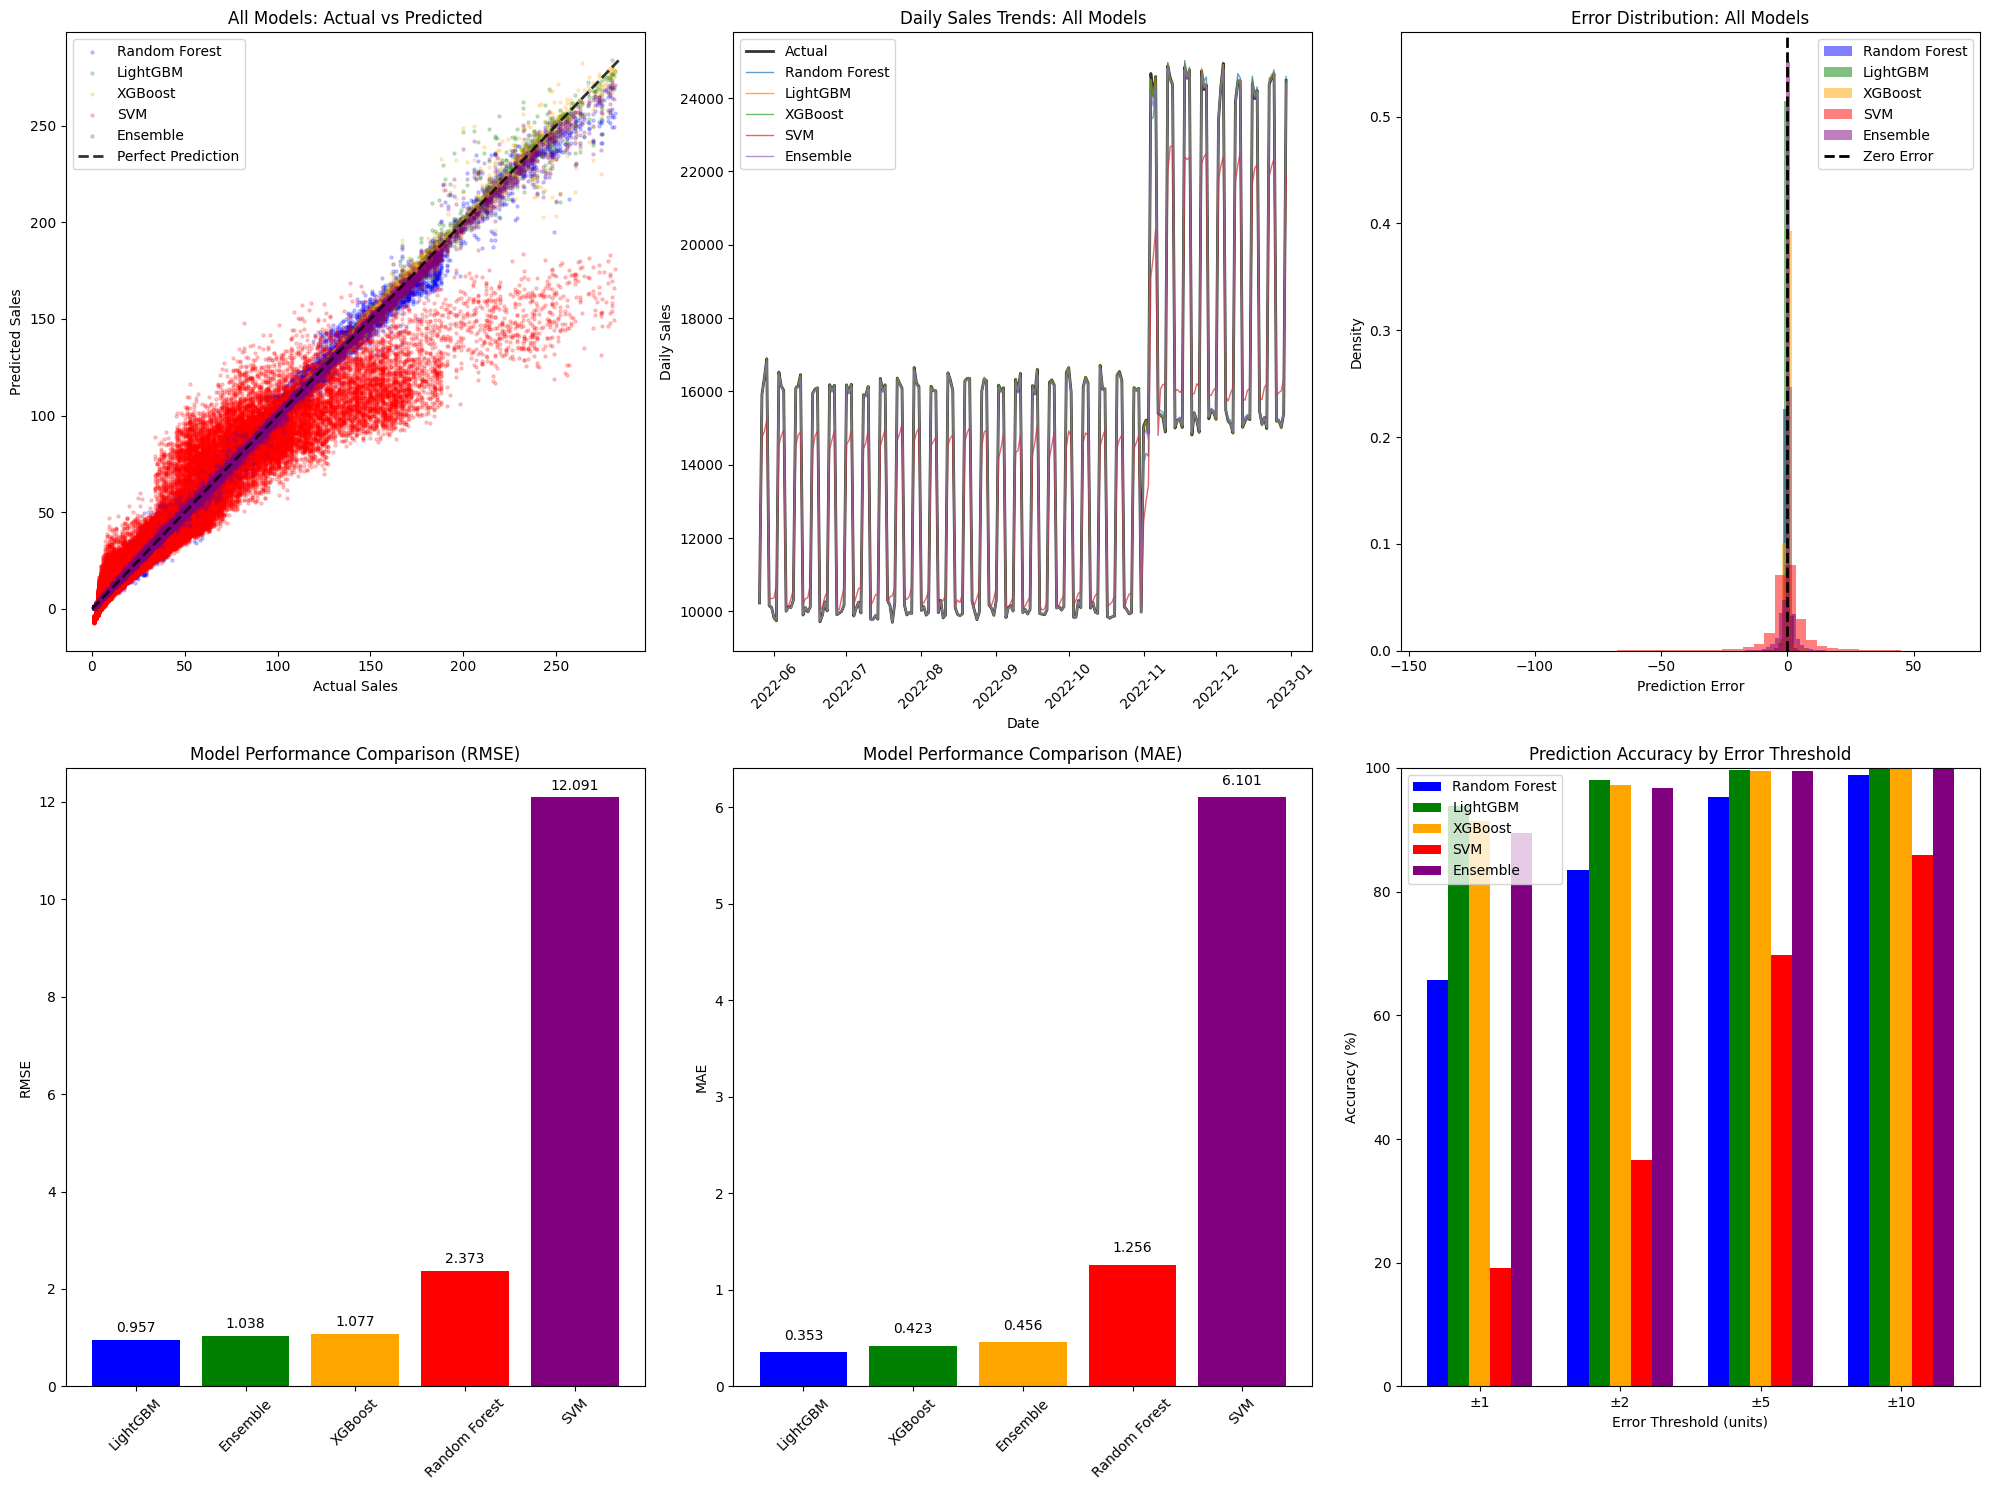

In [ ]:
plt.figure(figsize=(20, 15))

# 1. Actual vs Predicted Scatter for ALL models
plt.subplot(2, 3, 1)
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, (model_name, color) in enumerate(zip(models.keys(), colors)):
    plt.scatter(viz_data['actual'], viz_data[model_name], 
                alpha=0.2, s=5, color=color, label=model_name)
    
max_val = max(viz_data['actual'].max(), *[viz_data[model].max() for model in models.keys()])
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8, linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('All Models: Actual vs Predicted')
plt.legend()

# 2. Time-series trend (aggregated daily)
plt.subplot(2, 3, 2)
daily_agg = viz_data.groupby('sales_date').agg({
    'actual': 'sum',
    **{model: 'sum' for model in models.keys()}
}).reset_index()

plt.plot(daily_agg['sales_date'], daily_agg['actual'], 'k-', label='Actual', linewidth=2, alpha=0.8)
for model_name, color in zip(models.keys(), colors):
    plt.plot(daily_agg['sales_date'], daily_agg[model_name], 
             label=model_name, alpha=0.7, linewidth=1)
plt.title('Daily Sales Trends: All Models')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.legend()
plt.xticks(rotation=45)

# 3. Error distribution for ALL models
plt.subplot(2, 3, 3)
for model_name, color in zip(models.keys(), colors):
    errors = viz_data[model_name] - viz_data['actual']
    plt.hist(errors, bins=50, alpha=0.5, color=color, label=model_name, density=True)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Error Distribution: All Models')
plt.legend()

# 4. Model Performance Comparison (RMSE)
plt.subplot(2, 3, 4)
model_rmse = {}
for model_name in models.keys():
    rmse = np.sqrt(mean_squared_error(viz_data['actual'], viz_data[model_name]))
    model_rmse[model_name] = rmse

# Sort by RMSE (best to worst)
sorted_models = sorted(model_rmse.items(), key=lambda x: x[1])
model_names = [model[0] for model in sorted_models]
rmse_values = [model[1] for model in sorted_models]

bars = plt.bar(model_names, rmse_values, color=colors[:len(model_names)])
plt.ylabel('RMSE')
plt.title('Model Performance Comparison (RMSE)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.3f}', ha='center', va='bottom')

# 5. MAE Comparison
plt.subplot(2, 3, 5)
model_mae = {}
for model_name in models.keys():
    mae = np.mean(np.abs(viz_data[model_name] - viz_data['actual']))
    model_mae[model_name] = mae

# Sort by MAE (best to worst)
sorted_models_mae = sorted(model_mae.items(), key=lambda x: x[1])
model_names_mae = [model[0] for model in sorted_models_mae]
mae_values = [model[1] for model in sorted_models_mae]

bars = plt.bar(model_names_mae, mae_values, color=colors[:len(model_names_mae)])
plt.ylabel('MAE')
plt.title('Model Performance Comparison (MAE)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.3f}', ha='center', va='bottom')

# 6. Prediction Accuracy by Error Threshold
plt.subplot(2, 3, 6)
thresholds = [1, 2, 5, 10]
threshold_data = []

for model_name in models.keys():
    errors = np.abs(viz_data[model_name] - viz_data['actual'])
    accuracy_at_thresholds = [(errors <= threshold).mean() * 100 for threshold in thresholds]
    threshold_data.append(accuracy_at_thresholds)

x = np.arange(len(thresholds))
width = 0.15

for i, (model_name, accuracies) in enumerate(zip(models.keys(), threshold_data)):
    plt.bar(x + i*width, accuracies, width, label=model_name, color=colors[i])

plt.xlabel('Error Threshold (units)')
plt.ylabel('Accuracy (%)')
plt.title('Prediction Accuracy by Error Threshold')
plt.xticks(x + width*2, [f'±{t}' for t in thresholds])
plt.legend()
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

##### Print comprehensive metrics

In [ ]:
print(f"{'Model':<15} {'RMSE':<10} {'MAE':<10} {'R²':<8} {'±1 Unit':<10} {'±2 Units':<10}")

for model_name in sorted_models:  # Sorted by RMSE (best to worst)
    actual = viz_data['actual']
    predicted = viz_data[model_name[0]]
    
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = np.mean(np.abs(predicted - actual))
    r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))
    accuracy_1 = (np.abs(predicted - actual) <= 1).mean() * 100
    accuracy_2 = (np.abs(predicted - actual) <= 2).mean() * 100
    
    print(f"{model_name[0]:<15} {rmse:<10.4f} {mae:<10.4f} {r2:<8.4f} {accuracy_1:<10.1f}% {accuracy_2:<10.1f}%")

Model           RMSE       MAE        R²       ±1 Unit    ±2 Units  
LightGBM        0.9573     0.3531     0.9993   93.9      % 98.1      %
Ensemble        1.0383     0.4559     0.9991   89.6      % 96.8      %
XGBoost         1.0774     0.4227     0.9991   91.5      % 97.2      %
Random Forest   2.3733     1.2565     0.9955   65.7      % 83.5      %
SVM             12.0908    6.1007     0.8842   19.1      % 36.5      %


## 14: FUTURE DEMAND FORECASTING

Loading your Complete_Enhanced_Dataset.csv...

Dataset Info:
Records: 486,180
Date range: 2020-01-01 00:00:00 to 2022-12-30 00:00:00
Stores: 4
Products: 111
Feature info loaded: 15 features
All models loaded successfully

Creating future features based on your dataset structure...
Available columns in your dataset: ['sales_date', 'dealer_code', 'product', 'daily_sales_qty', 'daily_revenue', 'ending_inventory', 'day_of_week', 'month', 'sales_lag_1', 'sales_lag_7', 'sales_rolling_7', 'dealer_code_encoded', 'product_encoded', 'store_product_avg_sales', 'store_product_std_sales', 'year', 'quarter', 'is_weekend', 'avg_unit_price', 'inventory_turnover']
Forecasting period: 2022-12-31 00:00:00 to 2023-01-06 00:00:00
Future features created with 20 columns
Sample columns: ['sales_date', 'dealer_code', 'product', 'day_of_week', 'month', 'year', 'quarter', 'day_of_year', 'week_of_year', 'is_weekend']...
   Model expects 15 features: ['ending_inventory', 'day_of_week', 'month', 'sales_lag_1', 'sa

C:\Users\moksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\moksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


SVM predictions: 3108
Range: -4.08 to 166.37

All model predictions completed!

Future forecast saved: (3108, 18)


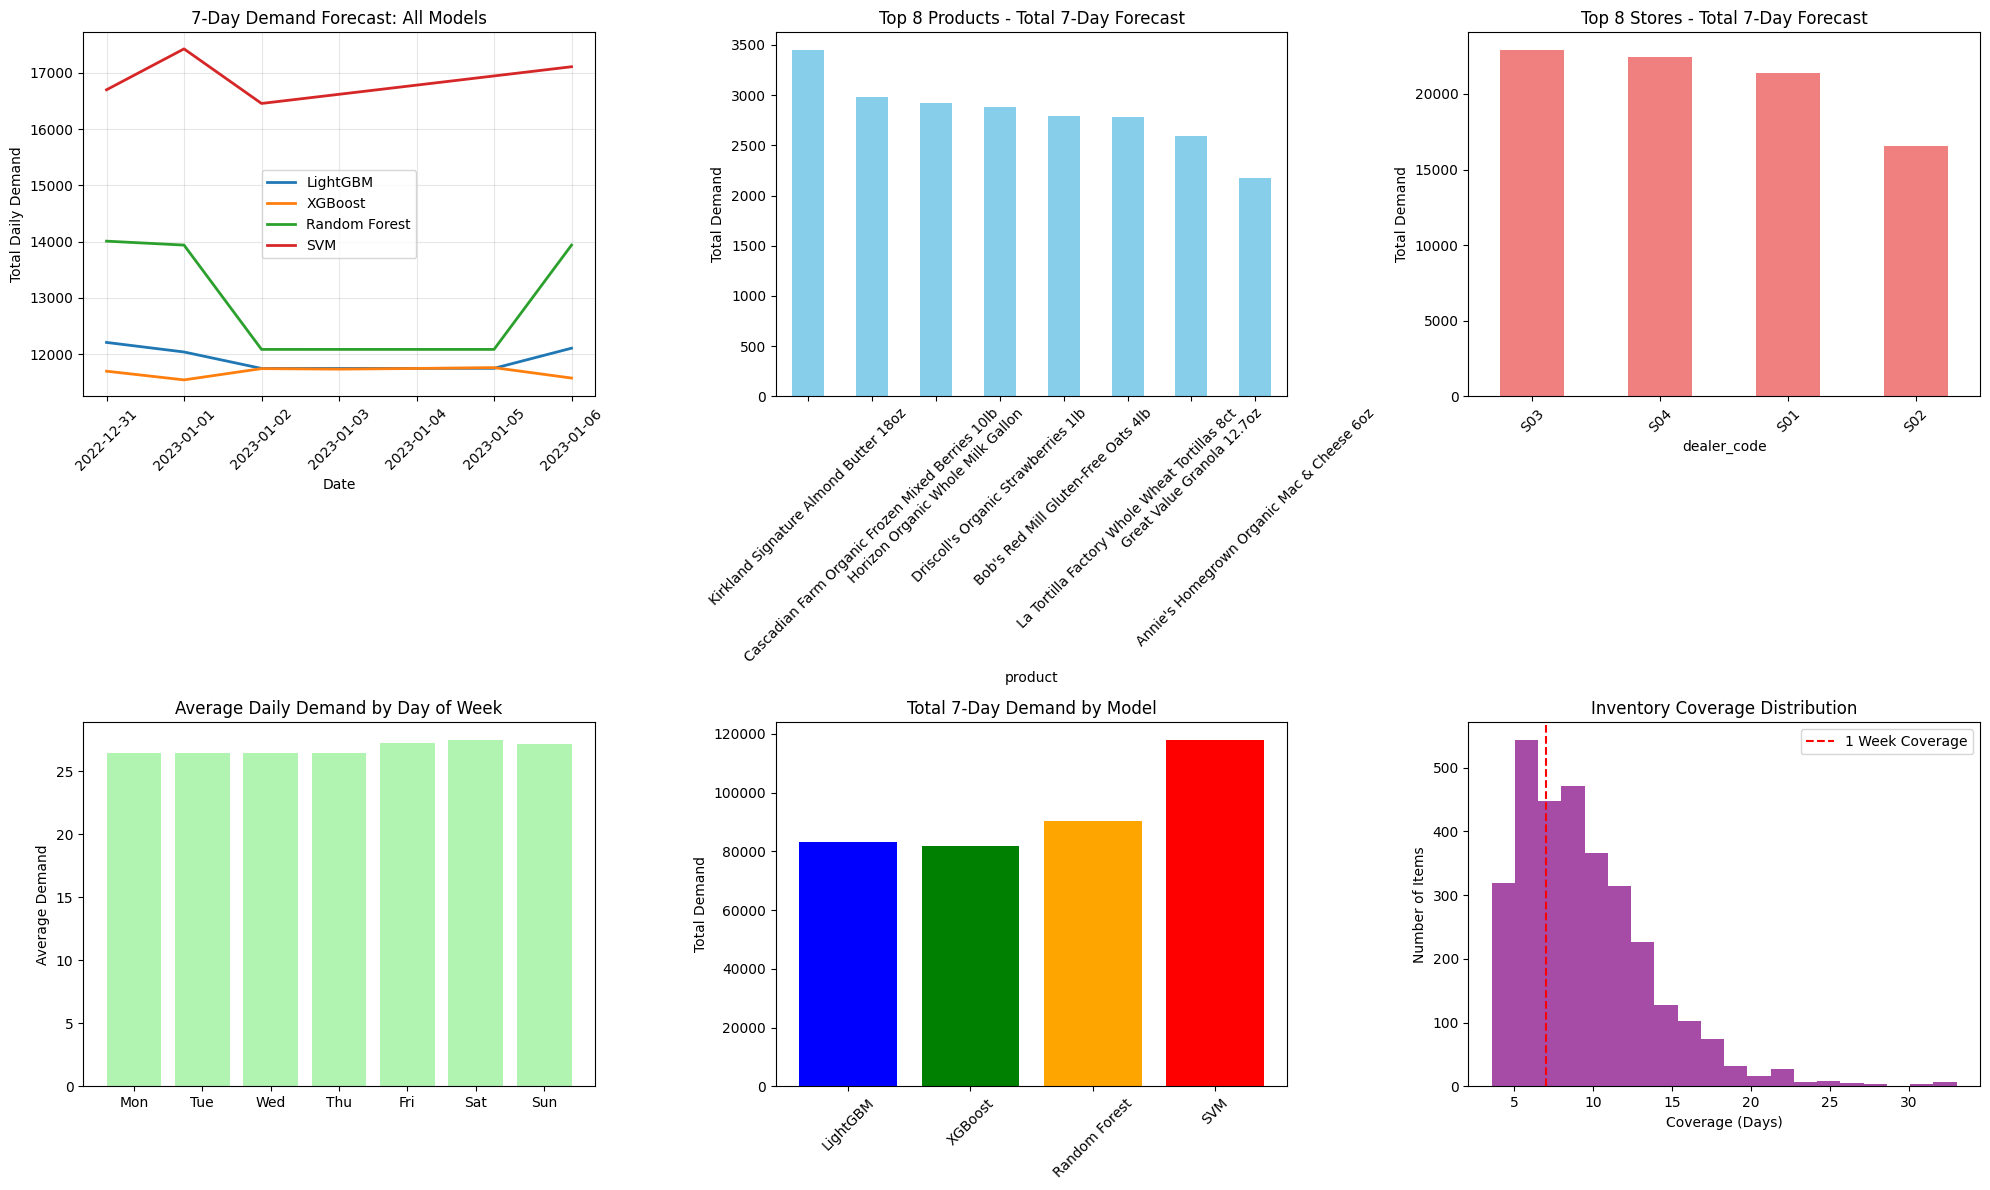


TOTAL 7-DAY DEMAND BY MODEL:
   SVM            :     118036 units
   Random Forest  :      90231 units
   LightGBM       :      83350 units
   XGBoost        :      81808 units

FORECAST SUMMARY:
Forecast Period: 2022-12-31 00:00:00 to 2023-01-06 00:00:00
Total Records: 3,108
Stores Covered: 4
Products Covered: 111


In [ ]:
def create_future_features_from_dataset(last_date, historical_data):
    print(f"Available columns in your dataset: {list(historical_data.columns)}")
    store_product_combinations = historical_data[['dealer_code', 'product']].drop_duplicates().values.tolist()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=7, freq='D')
    print(f"Forecasting period: {future_dates[0]} to {future_dates[-1]}")
    
    future_data = []
    for date in future_dates:
        for store, product in store_product_combinations:
            future_data.append({
                'sales_date': date,
                'dealer_code': store,
                'product': product
            })
    
    future_df = pd.DataFrame(future_data)
    
    # Basic temporal features
    future_df['day_of_week'] = future_df['sales_date'].dt.dayofweek
    future_df['month'] = future_df['sales_date'].dt.month
    future_df['year'] = future_df['sales_date'].dt.year
    future_df['quarter'] = future_df['sales_date'].dt.quarter
    future_df['day_of_year'] = future_df['sales_date'].dt.dayofyear
    future_df['week_of_year'] = future_df['sales_date'].dt.isocalendar().week
    future_df['is_weekend'] = (future_df['day_of_week'] >= 5).astype(int)
    
    agg_dict = {
        'ending_inventory': 'last',
        'sales_rolling_7': 'last',
        'sales_lag_1': 'last', 
        'sales_lag_7': 'last',
        'store_product_avg_sales': 'first',  
        'store_product_std_sales': 'first',
        'avg_unit_price': 'first',
        'inventory_turnover': 'first'
    }
    
    historical_patterns = historical_data.groupby(['dealer_code', 'product']).agg(agg_dict).reset_index()
    
    # Merge with future data
    future_df = pd.merge(future_df, historical_patterns, on=['dealer_code', 'product'], how='left')
    
    # Add encoded features (CRITICAL - must match training)
    future_df['dealer_code_encoded'] = future_df['dealer_code'].astype('category').cat.codes
    future_df['product_encoded'] = future_df['product'].astype('category').cat.codes
    
    # Fill missing values with 0 (for brand new products/stores)
    future_df = future_df.fillna(0)
    
    print(f"Future features created with {len(future_df.columns)} columns")
    print(f"Sample columns: {list(future_df.columns)[:10]}...")
    
    return future_df

def prepare_future_features_for_models(future_df, feature_cols):
    print(f"   Model expects {len(feature_cols)} features: {feature_cols}")

    if 'dealer_code_encoded' in feature_cols:
        future_df['dealer_code_encoded'] = future_df['dealer_code'].astype('category').cat.codes
    
    if 'product_encoded' in feature_cols:
        future_df['product_encoded'] = future_df['product'].astype('category').cat.codes
    
    missing_features = []
    for col in feature_cols:
        if col not in future_df.columns:
            missing_features.append(col)
            future_df[col] = 0
    
    if missing_features:
        print(f"Added {len(missing_features)} missing features: {missing_features}")
    
    # Only select the exact features needed
    X_future = future_df[feature_cols].copy()
    
    print(f"Future features prepared: {X_future.shape}")
    return X_future, future_df

# Load dataset
print("Loading your Complete_Enhanced_Dataset.csv...")
historical_data = pd.read_csv("./Output/Complete_Enhanced_Dataset.csv")
historical_data['sales_date'] = pd.to_datetime(historical_data['sales_date'])

print(f"\nDataset Info:")
print(f"Records: {len(historical_data):,}")
print(f"Date range: {historical_data['sales_date'].min()} to {historical_data['sales_date'].max()}")
print(f"Stores: {historical_data['dealer_code'].nunique()}")
print(f"Products: {historical_data['product'].nunique()}")

# Load feature info
try:
    feature_info = joblib.load('./Output/lightgbm_feature_info.pkl')
    feature_cols = feature_info['feature_names']
    print(f"Feature info loaded: {len(feature_cols)} features")
except:
    print("Could not load feature info, using basic features")
    feature_cols = ['day_of_week', 'month', 'year', 'is_weekend', 'avg_daily_sales', 
                   'dealer_code_encoded', 'product_encoded']

# Load models
try:
    lgb_model = joblib.load('./Output/lightgbm_model.pkl')
    xgb_model = joblib.load('./Output/xgboost_model.pkl')
    rf_model = joblib.load('./Output/random_forest_model.pkl')
    svm_model = joblib.load('./Output/svm_model.pkl')
    svm_scaler = joblib.load('./Output/svm_scaler.pkl')
    print("All models loaded successfully")
except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# Create future features
last_date = historical_data['sales_date'].max()
print(f"\nCreating future features based on your dataset structure...")
future_df = create_future_features_from_dataset(last_date, historical_data)

# Prepare features for models
X_future, future_df = prepare_future_features_for_models(future_df, feature_cols)

# Debug feature alignment
print(f"\n=== FEATURE ALIGNMENT DEBUG ===")
print(f"Model expects {len(feature_cols)} features")
print(f"X_future shape: {X_future.shape}")
print(f"X_future columns: {list(X_future.columns)}")

# Verify exact match
if X_future.shape[1] == len(feature_cols):
    print(f"Feature count matches!")
else:
    print(f"Feature count mismatch: {X_future.shape[1]} vs {len(feature_cols)}")

# Ensure columns are in the exact order expected by the model
X_future_aligned = X_future[feature_cols].copy()
print(f"Features aligned in correct order: {X_future_aligned.shape}")

# Convert to numpy array for models (avoids feature name issues)
X_future_array = X_future_aligned.values

# LightGBM
try:
    lgb_future_pred = lgb_model.predict(X_future_array)
    future_df['lightgbm_prediction'] = np.clip(lgb_future_pred, 0, None)
    print(f"LightGBM predictions: {len(lgb_future_pred)}")
    print(f"   Range: {lgb_future_pred.min():.2f} to {lgb_future_pred.max():.2f}")
except Exception as e:
    print(f"LightGBM prediction failed: {e}")
    future_df['lightgbm_prediction'] = 0

# XGBoost
try:
    xgb_future_pred = xgb_model.predict(X_future_array)
    future_df['xgboost_prediction'] = np.clip(xgb_future_pred, 0, None)
    print(f"XGBoost predictions: {len(xgb_future_pred)}")
    print(f"Range: {xgb_future_pred.min():.2f} to {xgb_future_pred.max():.2f}")
except Exception as e:
    print(f"XGBoost prediction failed: {e}")
    future_df['xgboost_prediction'] = 0

# Random Forest
try:
    rf_future_pred = rf_model.predict(X_future_array)
    future_df['random_forest_prediction'] = np.clip(rf_future_pred, 0, None)
    print(f"Random Forest predictions: {len(rf_future_pred)}")
    print(f"   Range: {rf_future_pred.min():.2f} to {rf_future_pred.max():.2f}")
except Exception as e:
    print(f"Random Forest prediction failed: {e}")
    future_df['random_forest_prediction'] = 0

# SVM
try:
    X_future_scaled = svm_scaler.transform(X_future_array)
    svm_future_pred = svm_model.predict(X_future_scaled)
    future_df['svm_prediction'] = np.clip(svm_future_pred, 0, None)
    print(f"SVM predictions: {len(svm_future_pred)}")
    print(f"Range: {svm_future_pred.min():.2f} to {svm_future_pred.max():.2f}")
except Exception as e:
    print(f"SVM prediction failed: {e}")
    future_df['svm_prediction'] = 0

print("\nAll model predictions completed!")

# Create forecast output
available_columns = ['sales_date', 'dealer_code', 'product', 'day_of_week', 'month', 'year',
                    'lightgbm_prediction', 'xgboost_prediction', 
                    'random_forest_prediction', 'svm_prediction']

# Add available features
for col in ['store_product_avg_sales', 'ending_inventory', 'sales_rolling_7', 'sales_lag_1', 'sales_lag_7']:
    if col in future_df.columns:
        available_columns.append(col)

future_forecast = future_df[available_columns].copy()

# Add best prediction (using LightGBM)
future_forecast['best_prediction'] = future_forecast['lightgbm_prediction']

# Add inventory coverage if available
if 'ending_inventory' in future_forecast.columns and 'best_prediction' in future_forecast.columns:
    future_forecast['inventory_cover_days'] = future_forecast['ending_inventory'] / (future_forecast['best_prediction'] + 1)

# Add demand vs historical comparison
if 'store_product_avg_sales' in future_forecast.columns:
    future_forecast['demand_vs_historical'] = future_forecast['best_prediction'] / (future_forecast['store_product_avg_sales'] + 1)

# Save main forecast
future_forecast.to_csv('./Final_Result/future_demand_forecast_complete.csv', index=False)
print(f"\nFuture forecast saved: {future_forecast.shape}")

# Create summaries
daily_product_summary = future_forecast.groupby(['sales_date', 'product']).agg({
    'lightgbm_prediction': 'sum',
    'xgboost_prediction': 'sum',
    'random_forest_prediction': 'sum',
    'svm_prediction': 'sum',
    'best_prediction': 'sum'
}).reset_index()
daily_product_summary.to_csv('./Final_Result/daily_product_forecast_summary.csv', index=False)

store_summary = future_forecast.groupby(['sales_date', 'dealer_code']).agg({
    'best_prediction': 'sum',
    'product': 'nunique'
}).reset_index()
store_summary.to_csv('./Final_Result/daily_store_forecast_summary.csv', index=False)

# Visualizations
plt.figure(figsize=(20, 12))

# 1. Overall daily demand trend
plt.subplot(2, 3, 1)
daily_trend = future_forecast.groupby('sales_date').agg({
    'lightgbm_prediction': 'sum',
    'xgboost_prediction': 'sum',
    'random_forest_prediction': 'sum',
    'svm_prediction': 'sum'
}).reset_index()

plt.plot(daily_trend['sales_date'], daily_trend['lightgbm_prediction'], label='LightGBM', linewidth=2)
plt.plot(daily_trend['sales_date'], daily_trend['xgboost_prediction'], label='XGBoost', linewidth=2)
plt.plot(daily_trend['sales_date'], daily_trend['random_forest_prediction'], label='Random Forest', linewidth=2)
plt.plot(daily_trend['sales_date'], daily_trend['svm_prediction'], label='SVM', linewidth=2)
plt.title('7-Day Demand Forecast: All Models')
plt.xlabel('Date')
plt.ylabel('Total Daily Demand')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2. Top products forecast
plt.subplot(2, 3, 2)
top_products = daily_product_summary.groupby('product')['best_prediction'].sum().nlargest(8)
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 8 Products - Total 7-Day Forecast')
plt.ylabel('Total Demand')
plt.xticks(rotation=45)

# 3. Top stores forecast
plt.subplot(2, 3, 3)
top_stores = store_summary.groupby('dealer_code')['best_prediction'].sum().nlargest(8)
top_stores.plot(kind='bar', color='lightcoral')
plt.title('Top 8 Stores - Total 7-Day Forecast')
plt.ylabel('Total Demand')
plt.xticks(rotation=45)

# 4. Day-of-week pattern
plt.subplot(2, 3, 4)
dow_pattern = future_forecast.groupby('day_of_week')['best_prediction'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, dow_pattern.values, color='lightgreen', alpha=0.7)
plt.title('Average Daily Demand by Day of Week')
plt.ylabel('Average Demand')

# 5. Model comparison
plt.subplot(2, 3, 5)
model_totals = {
    'LightGBM': future_forecast['lightgbm_prediction'].sum(),
    'XGBoost': future_forecast['xgboost_prediction'].sum(),
    'Random Forest': future_forecast['random_forest_prediction'].sum(),
    'SVM': future_forecast['svm_prediction'].sum()
}
plt.bar(model_totals.keys(), model_totals.values(), color=['blue', 'green', 'orange', 'red'])
plt.title('Total 7-Day Demand by Model')
plt.ylabel('Total Demand')
plt.xticks(rotation=45)

# 6. Inventory coverage or prediction distribution
plt.subplot(2, 3, 6)
if 'inventory_cover_days' in future_forecast.columns:
    coverage_data = future_forecast['inventory_cover_days']
    plt.hist(coverage_data, bins=20, color='purple', alpha=0.7)
    plt.axvline(x=7, color='red', linestyle='--', label='1 Week Coverage')
    plt.title('Inventory Coverage Distribution')
    plt.xlabel('Coverage (Days)')
    plt.ylabel('Number of Items')
    plt.legend()
else:
    plt.hist(future_forecast['best_prediction'], bins=20, color='purple', alpha=0.7)
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Demand')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('./Final_Result/complete_dataset_forecast_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
print(f"\n{'='*60}")
print(f"TOTAL 7-DAY DEMAND BY MODEL:")
print(f"{'='*60}")
for model, total in sorted(model_totals.items(), key=lambda x: x[1], reverse=True):
    print(f"   {model:<15}: {total:>10.0f} units")

print(f"\n{'='*60}")
print(f"FORECAST SUMMARY:")
print(f"{'='*60}")
print(f"Forecast Period: {future_forecast['sales_date'].min()} to {future_forecast['sales_date'].max()}")
print(f"Total Records: {len(future_forecast):,}")
print(f"Stores Covered: {future_forecast['dealer_code'].nunique()}")
print(f"Products Covered: {future_forecast['product'].nunique()}")
print(f"{'='*60}")

## 15: Inventory recommendation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib

def create_encoded_features(df, encoders=None, fit=False):

    if fit:
        dealer_encoder = LabelEncoder()
        product_encoder = LabelEncoder()
        
        df['dealer_code_encoded'] = dealer_encoder.fit_transform(df['dealer_code'])
        df['product_encoded'] = product_encoder.fit_transform(df['product'])
        
        encoders = {
            'dealer': dealer_encoder,
            'product': product_encoder
        }
    else:
        if encoders is None:
            raise ValueError("Must provide encoders when fit=False")
        
        df['dealer_code_encoded'] = encoders['dealer'].transform(df['dealer_code'])
        df['product_encoded'] = encoders['product'].transform(df['product'])
    
    return df, encoders


def forecast_with_updated_lags(models, historical_data, future_dates, feature_cols, encoders):

    forecasts = []
    
    # Get store-product combinations
    combinations = historical_data[['dealer_code', 'product']].drop_duplicates()
    
    # Keep track of recent predictions for lag features
    recent_predictions = {}
    
    for date in future_dates:
        daily_forecast = []
        
        for _, row in combinations.iterrows():
            store = row['dealer_code']
            product = row['product']
            
            # Get historical stats for this store-product
            hist_subset = historical_data[
                (historical_data['dealer_code'] == store) & 
                (historical_data['product'] == product)
            ]
            
            # Create features for this prediction
            features = {
                'sales_date': date,
                'dealer_code': store,
                'product': product,
                'day_of_week': date.dayofweek,
                'month': date.month,
                'year': date.year,
                'quarter': date.quarter,
                'is_weekend': int(date.dayofweek >= 5),
                'store_product_avg_sales': hist_subset['daily_sales_qty'].mean(),
                'store_product_std_sales': hist_subset['daily_sales_qty'].std(),
                'ending_inventory': hist_subset['ending_inventory'].iloc[-1] if len(hist_subset) > 0 else 0,
            }
            
            # Add avg_unit_price if available in historical data
            if 'daily_revenue' in hist_subset.columns and len(hist_subset) > 0:
                avg_revenue = hist_subset['daily_revenue'].mean()
                avg_qty = hist_subset['daily_sales_qty'].mean()
                features['avg_unit_price'] = avg_revenue / (avg_qty + 1) if avg_qty > 0 else 0
            else:
                features['avg_unit_price'] = 0
            
            # Add inventory_turnover
            if len(hist_subset) > 0:
                avg_sales = hist_subset['daily_sales_qty'].mean()
                avg_inventory = hist_subset['ending_inventory'].mean()
                features['inventory_turnover'] = avg_sales / (avg_inventory + 1) if avg_inventory > 0 else 0
            else:
                features['inventory_turnover'] = 0
            
            # Update lag features with recent predictions
            key = (store, product)
            if key in recent_predictions:
                # Use prediction from 1 day ago
                if len(recent_predictions[key]) >= 1:
                    features['sales_lag_1'] = recent_predictions[key][-1]
                # Use prediction from 7 days ago
                if len(recent_predictions[key]) >= 7:
                    features['sales_lag_7'] = recent_predictions[key][-7]
                # Rolling 7-day average of recent predictions
                features['sales_rolling_7'] = np.mean(recent_predictions[key][-7:])
            else:
                # Use last historical values
                features['sales_lag_1'] = hist_subset['sales_lag_1'].iloc[-1]
                features['sales_lag_7'] = hist_subset['sales_lag_7'].iloc[-1]
                features['sales_rolling_7'] = hist_subset['sales_rolling_7'].iloc[-1]
            
            # Fill missing values
            for k, v in features.items():
                if pd.isna(v):
                    features[k] = 0
            
            # Convert to DataFrame and encode
            feature_df = pd.DataFrame([features])
            feature_df, _ = create_encoded_features(feature_df, encoders=encoders, fit=False)
            
            # Add any missing features that model expects (fill with 0)
            for col in feature_cols:
                if col not in feature_df.columns:
                    feature_df[col] = 0
            
            # Ensure correct feature order
            X = feature_df[feature_cols].values
            
            # Get predictions from all models
            lgb_pred = models['lightgbm'].predict(X)[0]
            xgb_pred = models['xgboost'].predict(X)[0]
            rf_pred = models['random_forest'].predict(X)[0]
            svm_pred = models['svm'].predict(models['scaler'].transform(X))[0]
            
            # Weighted ensemble
            weights = models['weights']
            ensemble_pred = (
                lgb_pred * weights['lightgbm'] +
                xgb_pred * weights['xgboost'] +
                rf_pred * weights['random_forest'] +
                svm_pred * weights['svm']
            )
            
            # Store prediction for future lag calculations
            if key not in recent_predictions:
                recent_predictions[key] = []
            recent_predictions[key].append(max(0, ensemble_pred))
            
            # Add to daily forecast
            daily_forecast.append({
                'sales_date': date,
                'dealer_code': store,
                'product': product,
                'lightgbm_prediction': max(0, lgb_pred),
                'xgboost_prediction': max(0, xgb_pred),
                'random_forest_prediction': max(0, rf_pred),
                'svm_prediction': max(0, svm_pred),
                'ensemble_prediction': max(0, ensemble_pred)
            })
        
        forecasts.extend(daily_forecast)
    
    return pd.DataFrame(forecasts)

def add_inventory_recommendations(forecast_df, historical_data, safety_factor=1.5, forecast_horizon=7):

    result = forecast_df.copy()
    
    # Calculate safety stock based on demand variability
    demand_stats = historical_data.groupby(['dealer_code', 'product']).agg({
        'daily_sales_qty': ['mean', 'std']
    }).reset_index()
    demand_stats.columns = ['dealer_code', 'product', 'avg_demand', 'std_demand']
    
    # Merge stats
    result = result.merge(demand_stats, on=['dealer_code', 'product'], how='left')
    
    # Fill NaN values
    result['std_demand'] = result['std_demand'].fillna(result['avg_demand'] * 0.3)  # Assume 30% CV if missing
    
    # Calculate safety stock (buffer for variability)
    result['safety_stock'] = result['std_demand'] * safety_factor
    
    # Calculate total demand for forecast period (sum across all days for this store-product)
    total_demand = result.groupby(['dealer_code', 'product'])['ensemble_prediction'].sum().reset_index()
    total_demand.columns = ['dealer_code', 'product', 'total_forecast_demand']
    result = result.merge(total_demand, on=['dealer_code', 'product'], how='left')
    
    # Recommended stock = total forecast demand + safety stock
    result['recommended_stock'] = result['total_forecast_demand'] + result['safety_stock']
    
    # Add current inventory (from last known value)
    last_inventory = historical_data.groupby(['dealer_code', 'product'])['ending_inventory'].last().reset_index()
    last_inventory.columns = ['dealer_code', 'product', 'current_inventory']
    result = result.merge(last_inventory, on=['dealer_code', 'product'], how='left')
    result['current_inventory'] = result['current_inventory'].fillna(0)
    
    # Calculate order needed (only on first day of forecast for each store-product)
    result['order_needed'] = np.maximum(0, result['recommended_stock'] - result['current_inventory'])
    
    # Days of inventory coverage
    result['days_of_coverage'] = result['current_inventory'] / (result['ensemble_prediction'] + 0.1)
    
    # Flag situations using PROPER LOGIC
    # Priority order matters: most critical conditions last (they overwrite)
    result['status'] = 'OVERSTOCK'  # Default
    result.loc[result['current_inventory'] >= result['total_forecast_demand'] * 0.8, 'status'] = 'OK'
    result.loc[result['current_inventory'] < result['total_forecast_demand'], 'status'] = 'LOW_STOCK'
    result.loc[result['days_of_coverage'] < 3, 'status'] = 'CRITICAL_LOW'
    
    return result

def validate_predictions(predictions_df):

    print("\n=== PREDICTION VALIDATION ===")
    
    # Check product variation
    product_variation = predictions_df.groupby('product')['ensemble_prediction'].agg(['mean', 'std', 'min', 'max'])
    zero_var_products = (product_variation['std'] == 0).sum()
    
    print(f"Products with zero variation: {zero_var_products}/{len(product_variation)}")
    print(f"Products with predictions: {len(product_variation)}")
    
    if zero_var_products > 0:
        print("⚠️ WARNING: Some products have identical predictions across all stores!")
        print(product_variation[product_variation['std'] == 0].head())
    
    # Check store variation
    store_variation = predictions_df.groupby('dealer_code')['ensemble_prediction'].agg(['mean', 'std', 'min', 'max'])
    zero_var_stores = (store_variation['std'] == 0).sum()
    
    print(f"\nStores with zero variation: {zero_var_stores}/{len(store_variation)}")
    
    if zero_var_stores > 0:
        print("WARNING: Some stores have identical predictions across all products!")
    
    # Check if predictions are reasonable
    print(f"\nPrediction statistics:")
    print(f"  Min: {predictions_df['ensemble_prediction'].min():.2f}")
    print(f"  Max: {predictions_df['ensemble_prediction'].max():.2f}")
    print(f"  Mean: {predictions_df['ensemble_prediction'].mean():.2f}")
    print(f"  Std: {predictions_df['ensemble_prediction'].std():.2f}")
    print(f"  Unique values: {predictions_df['ensemble_prediction'].nunique()}")
    
    # Sample check
    print("\nSample predictions by store-product:")
    sample = predictions_df[['dealer_code', 'product', 'ensemble_prediction']].drop_duplicates().head(10)
    print(sample)
    
    return zero_var_products == 0 and zero_var_stores == 0


if __name__ == "__main__":
    # Load data
    historical_data = pd.read_csv("./Output/Complete_Enhanced_Dataset.csv")
    historical_data['sales_date'] = pd.to_datetime(historical_data['sales_date'])
    
    # Create and save encoders during training
    historical_data, encoders = create_encoded_features(historical_data, fit=True)
    joblib.dump(encoders, './Output/label_encoders.pkl')
    
    # Load trained models
    models = {
        'lightgbm': joblib.load('./Output/lightgbm_model.pkl'),
        'xgboost': joblib.load('./Output/xgboost_model.pkl'),
        'random_forest': joblib.load('./Output/random_forest_model.pkl'),
        'svm': joblib.load('./Output/svm_model.pkl'),
        'scaler': joblib.load('./Output/svm_scaler.pkl'),
        'weights': {
            'lightgbm': 0.4,
            'xgboost': 0.3,
            'random_forest': 0.2,
            'svm': 0.1
        }
    }
    
    # Load feature info
    feature_info = joblib.load('./Output/lightgbm_feature_info.pkl')
    feature_cols = feature_info['feature_names']
    
    # Generate future dates
    last_date = historical_data['sales_date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
    
    # Generate forecasts with proper lag handling
    forecasts = forecast_with_updated_lags(
        models=models,
        historical_data=historical_data,
        future_dates=future_dates,
        feature_cols=feature_cols,
        encoders=encoders
    )
    
    # Validate predictions
    is_valid = validate_predictions(forecasts)
    
    if is_valid:
        print("Predictions look good!")
    else:
        print("Predictions have issues - review feature engineering")
    
    # Add business logic
    final_recommendations = add_inventory_recommendations(forecasts, historical_data)
    
    # Save results
    final_recommendations.to_csv('./Final_Result/final_inventory_recommendations.csv', index=False)
    
    # Summary by status
    print("\n=== INVENTORY STATUS SUMMARY ===")
    status_summary = final_recommendations.groupby('status').agg({
        'order_needed': 'sum',
        'product': 'count'
    }).reset_index()
    print(status_summary)

C:\Users\moksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\moksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\moksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\moksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Pyth


=== PREDICTION VALIDATION ===
Products with zero variation: 0/111
Products with predictions: 111

Stores with zero variation: 0/4

Prediction statistics:
  Min: 1.01
  Max: 173.96
  Mean: 30.10
  Std: 29.67
  Unique values: 3108

Sample predictions by store-product:
  dealer_code                                            product  \
0         S01                   3M Scotch Double-Sided Tape 6636   
1         S01                           Acer Predator Helios 300   
2         S01                               Adidas Ultraboost 22   
3         S01                 Adidas Ultraboost 22 Running Shoes   
4         S01  Annie's Homegrown Organic Bunny Fruit Snacks 12ct   
5         S01         Annie's Homegrown Organic Mac & Cheese 6oz   
6         S01                          Apple AirPods Pro 2nd Gen   
7         S01                Arm & Hammer Super Scoop Cat Litter   
8         S01     Arrowhead Mills Organic Whole Wheat Bread 24oz   
9         S01                              Asus ROG 